---
**License**

 VacuumStudy

 Mon Jun 01 09:20:00 2020
 Copyright  2020
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 VacuumStudy
 Copyright (C) 2020 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from IPython.display import HTML

from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
%matplotlib inline

# Figure utilities

In [2]:
fig_width_pt  = 246.0 * 2.0                 # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0 / 72.27                 # Convert pt to inch
golden_mean   = (math.sqrt (5) - 1.0) / 2.0 # Aesthetic ratio
fig_width     = fig_width_pt*inches_per_pt  # width in inches
fig_height    = fig_width*golden_mean       # height in inches
fig_size      = [ fig_width, fig_height ]

params = {
          'axes.labelsize' : 10,
          'font.size'      : 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex'    : True,
          'figure.figsize' : fig_size,
          'animation.embed_limit' : 2**128
         }

mpl.rcParams.update (params)

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if base == 1.0:
          if exponent == 0.0:
            return r"1"
          else:
            return r"10^{{{1}}}".format (int(exponent))
        elif exponent == 0.0:
          return r"{0}".format (base)
        else:
          return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

# Initializing the library

In [3]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# Complex structure quantization object

Below we define our object as a child of the complex structure quantization object Ncm.CSQ1D

In [4]:
csq1d = Nc.DECont (Omegaw = 0.3, OmegaL = 0.7, w = 1.0e-1, cs2 = 1.0e-1)
csq1d.set_reltol (1.0e-12)

ti = 1.0e-8
tf = 1.0e10

ki    = 1.0e0
kf    = 1.0e3
k_a   = np.geomspace (ki, kf, 1000)

k = kf
csq1d.set_k (k)
csq1d.prepare_prop (None, 0.0, 1.0e-30, 1.0e1)

mylw = 1.0
ntheta = 8

theta_a = np.linspace (0.0, 2.0 * math.pi, ntheta, endpoint=False)
r_a = np.array ([1.0e-04, 1.0e-03, 1.0e-02, 1.0e-1, 1.0, 3.0, 6.0])
r_a = np.geomspace (1.0e-5, 1.0e-1, 4)
colors = cm.summer(np.linspace(0, 1, len(r_a)))

<function matplotlib.pyplot.show(close=None, block=None)>

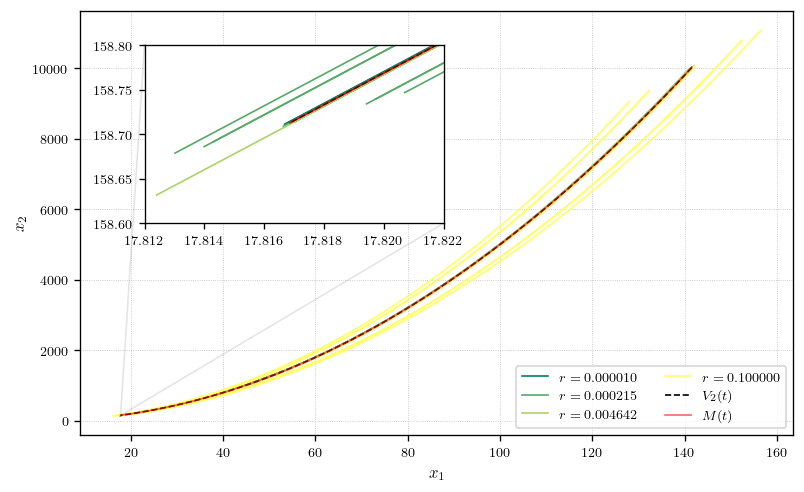

In [5]:
ti = 1.0e-8
tf = 1.0e-5

N = 2000
   
t_a = np.geomspace (ti, tf, N)

fig, ax = plt.subplots(dpi=120)
axin1 = ax.inset_axes([0.09, 0.5, 0.42, 0.42])

frame = 0

x0_a   = []
lny0_a = []
xV_a   = []
lnyV_a = []

chiV0 = 0.0
UpV0 = 0.0

gammaV = UpV0 - 0.5 * math.log1p (chiV0 * chiV0)
alphaV = math.asinh (chiV0)

for t in t_a:
    (chi, Up)   = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chiV0, UpV0)
    (chiV, UpV) = csq1d.eval_nonadiab_at (None, 0, t)
    
    x0_a.append (chi)
    lny0_a.append (math.sinh(-Up) + 0.5 * math.exp (-Up) * chi**2)

    xV_a.append (chiV)
    lnyV_a.append (math.sinh(-UpV) + 0.5 * math.exp (-UpV) * chiV**2)

x0_a = np.array (x0_a)
lny0_a = np.array (lny0_a)

for r, c in zip (r_a, colors):
    for theta in theta_a:
        x_a   = []
        lny_a = []
                
        alpha0, gamma0 = csq1d.alpha_gamma_circle (None, alphaV, gammaV, r, theta)
  
        chi0 = math.sinh (alpha0)
        Up0  = gamma0 + 0.5 * math.log1p (chi0 * chi0)

        for t in t_a:
            (chi, Up) = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chi0, Up0)
            #x_a.append (chi / math.exp (Up))
            #lny_a.append (-Up)
            gamma = Up - 0.5 * math.log1p (chi*chi) 
            x_a.append (chi)
            lny_a.append (-math.sqrt (1.0 + chi * chi) * math.sinh (gamma))
        
        x_a = np.array (x_a)
        lny_a = np.array (lny_a)
        
        if theta == 0:
            plt.plot (x_a, lny_a, lw=mylw, color=c, label = r"$r=%f$"%r)
        else:
            plt.plot (x_a, lny_a, lw=mylw, color=c)
            
        axin1.plot (x_a, lny_a, lw=mylw, color=c)

plt.plot (xV_a, lnyV_a, 'k--', lw=mylw, label = r'$V_2(t)$', alpha=1.0)
plt.plot (x0_a, lny0_a, 'r-',  lw=mylw, label = r'$M(t)$', alpha=0.6)

axin1.plot (x0_a, lny0_a, 'r-',  lw=mylw, label = r'$M(t)$', alpha=1.0)
axin1.plot (xV_a, lnyV_a, 'k--', lw=mylw, label = r'$V_2(t)$', alpha=0.6)

plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2)
#plt.xscale("symlog", linthresh=1.0e-1)
#plt.yscale("symlog", linthresh=1.0e-1)
#plt.xscale("log")
#plt.yscale("log")

axin1.set_xlim(17.812, 17.822)
axin1.set_ylim(158.6, 158.8)

ax.indicate_inset_zoom(axin1, edgecolor="black", alpha=0.1)

plt.xlabel ("$x_1$")
plt.ylabel ("$x_2$")

#plt.axis('equal')
fig.tight_layout ()

plt.savefig ("nonadiab_vacuum_f0.pdf")
plt.show

-0.00011523809523809521 7.1252887517460825e-06 0.001906658472549961 0.032149216558617674 -6.757325464018604e-05


<function matplotlib.pyplot.show(close=None, block=None)>

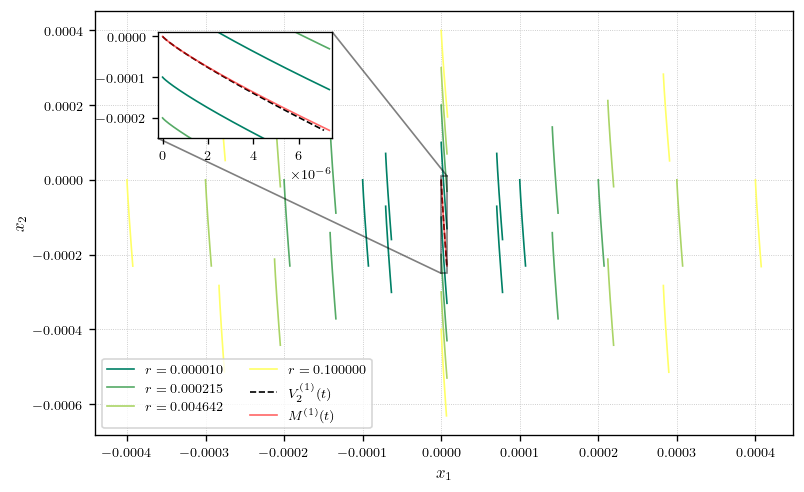

In [6]:
ti = 1.0e-8
tf = 2.2e-5

N = 2000
   
t_a = np.geomspace (ti, tf, N)

fig, ax = plt.subplots (dpi=120)

axin1 = ax.inset_axes([0.09, 0.7, 0.25, 0.25])


frame = 1

x0_a   = []
lny0_a = []
xV_a   = []
lnyV_a = []

chiV0 = 0.0
UpV0 = 0.0

gammaV = UpV0 - 0.5 * math.log1p (chiV0 * chiV0)
alphaV = math.asinh (chiV0)

for t in t_a:
    (chi, Up)   = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chiV0, UpV0)
    (chiV, UpV) = csq1d.eval_nonadiab_at (None, frame, t)
    
    x0_a.append (chi)
    lny0_a.append (math.sinh(-Up) + 0.5 * math.exp (-Up) * chi**2)

    xV_a.append (chiV)
    lnyV_a.append (math.sinh(-UpV) + 0.5 * math.exp (-UpV) * chiV**2)

x0_a = np.array (x0_a)
lny0_a = np.array (lny0_a)

l = 0.0

for r, c in zip (r_a, colors):
    for theta in theta_a:
        x_a   = []
        lny_a = []
                
        alpha0, gamma0 = csq1d.alpha_gamma_circle (None, alphaV, gammaV, r, theta)
  
        chi0 = math.sinh (alpha0)
        Up0  = gamma0 + 0.5 * math.log1p (chi0 * chi0)

        for t in t_a:
            (chi, Up) = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chi0, Up0)

            gamma = Up - 0.5 * math.log1p (chi*chi) 
            x_a.append (chi)
            lny_a.append (-math.sqrt (1.0 + chi * chi) * math.sinh (gamma))

        mx = x_a[0]
        mlny = lny_a[0]
        r0 = math.hypot (mx, mlny)
        
        nx = mx / r0
        nlny = mlny / r0
        
        x_a = np.array (x_a) - mx + nx * 1.0e-4 * (1.0 + l)
        lny_a = np.array (lny_a) - mlny + nlny * 1.0e-4 * (1.0 + l)
        
        x_a = np.array (x_a)
        lny_a = np.array (lny_a)
        
        if theta == 0:
            plt.plot (x_a, lny_a, lw=mylw, color=c, label = r"$r=%f$"%r)
        else:
            plt.plot (x_a, lny_a, lw=mylw, color=c)
            
        axin1.plot (x_a, lny_a, lw=mylw, color=c)
        
    l = l + 1.0


print (csq1d.eval_int_qmnu2 (None, tf, k), 
       csq1d.eval_int_mnu2 (None, tf, k), 
       csq1d.eval_int_q2mnu2 (None, tf, k), 
       (x0_a[-1] - xV_a[-1])/x0_a[-1],
       (lny0_a[-1] - lnyV_a[-1])/lny0_a[-1]
      )
    
plt.plot (xV_a, lnyV_a, 'k--', lw=mylw, label = r'$V_2^{(1)}(t)$', alpha=1.0)
plt.plot (x0_a, lny0_a, 'r-',  lw=mylw, label = r'$M^{(1)}(t)$', alpha=0.6)

axin1.plot (xV_a, lnyV_a, 'k--', lw=mylw, label = r'$V_2^{(1)}(t)$', alpha=1.0)
axin1.plot (x0_a, lny0_a, 'r-',  lw=mylw, label = r'$M^{(1)}(t)$', alpha=0.6)


plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2)
#plt.xscale("symlog", linscale=6.0e-1, linthresh=1.0e-2)
#plt.yscale("symlog", linscale=6.0e-1, linthresh=1.0e-2)

axin1.set_xlim(-0.2e-6, +7.5e-6)
axin1.set_ylim(-25.0e-5, +1.0e-5)

ax.indicate_inset_zoom(axin1, edgecolor="black")

plt.xlabel ("$x_1$")
plt.ylabel ("$x_2$")

fig.tight_layout ()

plt.savefig ("nonadiab_vacuum_f1.pdf")
plt.show

-2.380952380952381e-05 1.162064684096689e-06 0.0004990618247959693 1.2816539297913634e-08 6.66258488853016e-10


<function matplotlib.pyplot.show(close=None, block=None)>

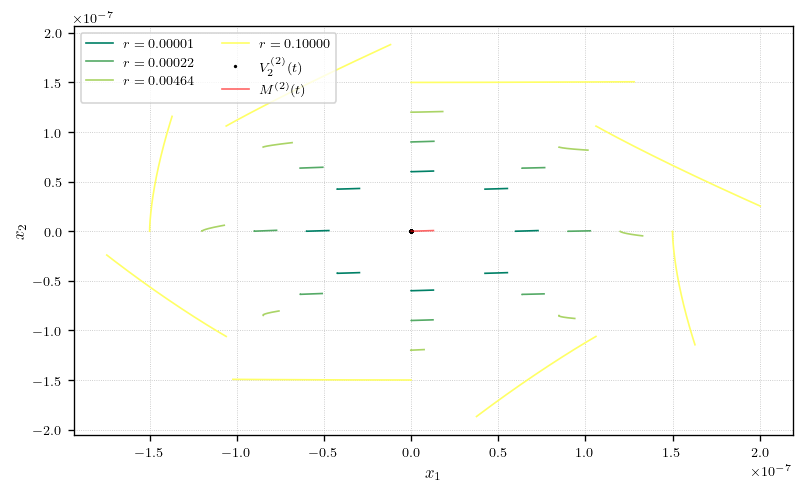

In [7]:
ti = 1.0e-8
tf = 1.0e-5

N = 2000
   
t_a = np.geomspace (ti, tf, N)

fig = plt.figure (dpi=120)

frame = 2

x0_a   = []
lny0_a = []
xV_a   = []
lnyV_a = []

chiV0 = 0.0
UpV0 = 0.0

gammaV = UpV0 - 0.5 * math.log1p (chiV0 * chiV0)
alphaV = math.asinh (chiV0)

for t in t_a:
    (chi, Up)   = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chiV0, UpV0)
    (chiV, UpV) = csq1d.eval_nonadiab_at (None, frame, t)
    
    x0_a.append (chi)
    lny0_a.append (math.sinh(-Up) + 0.5 * math.exp (-Up) * chi**2)

    xV_a.append (chiV)
    lnyV_a.append (math.sinh(-UpV) + 0.5 * math.exp (-UpV) * chiV**2)

x0_a = np.array (x0_a)
lny0_a = np.array (lny0_a)

l=0.0
for r, c in zip (r_a, colors):
    for theta in theta_a:
        x_a   = []
        lny_a = []
                
        alpha0, gamma0 = csq1d.alpha_gamma_circle (None, alphaV, gammaV, r, theta)
  
        chi0 = math.sinh (alpha0)
        Up0  = gamma0 + 0.5 * math.log1p (chi0 * chi0)

        for t in t_a:
            (chi, Up) = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chi0, Up0)

            gamma = Up - 0.5 * math.log1p (chi*chi) 
            x_a.append (chi)
            lny_a.append (-math.sqrt (1.0 + chi * chi) * math.sinh (gamma))
        
        mx = x_a[0]
        mlny = lny_a[0]
        r0 = math.hypot (mx, mlny)
        
        nx = mx / r0
        nlny = mlny / r0
        
        rho_a = np.hypot (x_a, lny_a) * 1.0e-9
        phi_a = np.arctan2 (lny_a, x_a)
        
        #x_a = rho_a * np.cos (phi_a)
        #lny_a = rho_a * np.sin (phi_a)
        
        x_a = np.array (x_a) - mx + nx * 6.0e-8 * (1.0 + l/2.0)
        lny_a = np.array (lny_a) - mlny + nlny * 6.0e-8 * (1.0 + l/2.0)
        
        if theta == 0:
            plt.plot (x_a, lny_a, lw=mylw, color=c, label = r"$r=%.5f$" % (r))
        else:
            plt.plot (x_a, lny_a, lw=mylw, color=c)

    l = l + 1.0

    
print (csq1d.eval_int_qmnu2 (None, tf, k), 
       csq1d.eval_int_mnu2 (None, tf, k), 
       csq1d.eval_int_q2mnu2 (None, tf, k), 
       (x0_a[-1] - xV_a[-1]),
       (lny0_a[-1] - lnyV_a[-1])
      )

plt.plot (xV_a, lnyV_a, 'o', color='k', lw=mylw, label = r'$V_2^{(2)}(t)$', alpha=1.0, markersize=1)
plt.plot (x0_a, lny0_a, 'r-',  lw=mylw, label = r'$M^{(2)}(t)$', alpha=0.6)
        
plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="upper left", ncol = 2)
#plt.xscale("symlog", linscale=6.0e-1, linthresh=1.0e-6)
#plt.yscale("symlog", linscale=6.0e-1, linthresh=1.0e-6)

plt.xlabel ("$x_1$")
plt.ylabel ("$x_2$")

#plt.axis('equal')
fig.tight_layout ()

plt.savefig ("nonadiab_vacuum_f2.pdf")
plt.show

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

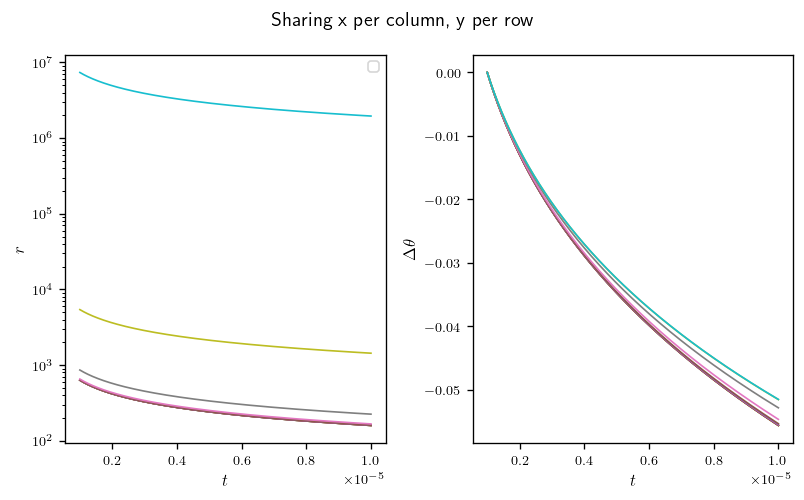

In [8]:
ti = 1.0e-6
tf = 1.0e-5

N = 2000
   
t_a = np.geomspace (ti, tf, N)

fig = plt.figure (dpi=120)
gs = fig.add_gridspec(1, 2)
(ax1, ax2) = gs.subplots()
fig.suptitle('Sharing x per column, y per row')

frame = 0

x0_a   = []
lny0_a = []
xV_a   = []
lnyV_a = []

chiV0 = 0.0
UpV0 = 0.0

gammaV = UpV0 - 0.5 * math.log1p (chiV0 * chiV0)
alphaV = math.asinh (chiV0)

for t in t_a:
    (chi, Up)   = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chiV0, UpV0)
    (chiV, UpV) = csq1d.eval_nonadiab_at (None, 0, t)
    
    x0_a.append (chi)
    lny0_a.append (math.sinh(-Up) + 0.5 * math.exp (-Up) * chi)

    xV_a.append (chiV)
    lnyV_a.append (math.sinh(-UpV) + 0.5 * math.exp (-UpV) * chiV)

x0_a = np.array (x0_a)
lny0_a = np.array (lny0_a)

for r in np.geomspace (1.0e-4, 1.0e1, 10):
    for theta in theta_a[0:1]:
        x_a   = []
        lny_a = []
                
        alpha0, gamma0 = csq1d.alpha_gamma_circle (None, alphaV, gammaV, r, theta)
  
        chi0 = math.sinh (alpha0)
        Up0  = gamma0 + 0.5 * math.log1p (chi0 * chi0)

        for t in t_a:
            (chi, Up) = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chi0, Up0)
            #x_a.append (chi / math.exp (Up))
            #lny_a.append (-Up)
            gamma = Up - 0.5 * math.log1p (chi*chi) 
            x_a.append (chi)
            lny_a.append (-math.sqrt (1.0 + chi * chi) * math.sinh (gamma))
        
        x_a = np.array (x_a)
        lny_a = np.array (lny_a)
        
        rho_a = np.hypot (x_a, lny_a)
        phi_a = np.arctan2 (lny_a, x_a)
        
        ax1.plot (t_a, rho_a, lw=mylw)
        ax2.plot (t_a, phi_a-phi_a[0], lw=mylw)

rho0_a = np.hypot (x0_a, lny0_a)
phi0_a = np.arctan2 (lny0_a, x0_a)

rhoV_a = np.hypot (xV_a, lnyV_a)
phiV_a = np.arctan2 (lnyV_a, xV_a)

#ax1.plot (t_a, rho0_a, 'k-',  lw=mylw, label = r'$M(t)$')
#ax2.plot (t_a, phi0_a-phi0_a[0], 'k-',  lw=mylw, label = r'$M(t)$')

#ax1.plot (t_a, rhoV_a, 'k-',  lw=mylw, label = r'$V(t)$')
#ax2.plot (t_a, phiV_a-phiV_a[0], 'k-',  lw=mylw, label = r'$V(t)$')
        
#ax1.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
#ax2.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = ax1.legend (loc="best", ncol = 2)
#ax1.set_xscale("log")
ax1.set_yscale("log")

#ax2.set_xscale("log")
#ax2.set_yscale("symlog")

ax1.set_xlabel ("$t$")
ax1.set_ylabel ("$r$")

ax2.set_xlabel ("$t$")
ax2.set_ylabel (r"$\Delta\theta$")

#plt.axis('equal')
fig.tight_layout ()

plt.savefig ("nonadiab_vacuum_f0_xy.pdf")
plt.show

In [9]:
csq1d = Nc.DECont (Omegaw = 0.3, OmegaL = 0.7, w = 1.0e-3, cs2 = 1.0e-3)
#csq1d.set_reltol (1.0e-11)

def compute_J(k):
    csq1d.set_k (k)
    csq1d.prepare_prop (None, 0.0, 1.0e-30, 1.0e1)

    (chi, Up) = csq1d.evolve_prop_vector_chi_Up (None, tf, frame, chiV, UpV)
    csq1d.set_init_cond (Ncm.CSQ1DEvolState.UP, tf, chi, Up)
    csq1d.set_tf (1.0e10)
    csq1d.prepare ()

    t_a, t_s = csq1d.get_time_array ()

    J = csq1d.get_J_at (None, t_a[-1])
    
    return J

In [10]:
J_a = []
k_a = np.geomspace (1.0e-2, 1.0e3, 3000)
for k in k_a:
    J_a.append (np.array(list(compute_J(k))))
    
J_a = np.array (J_a)

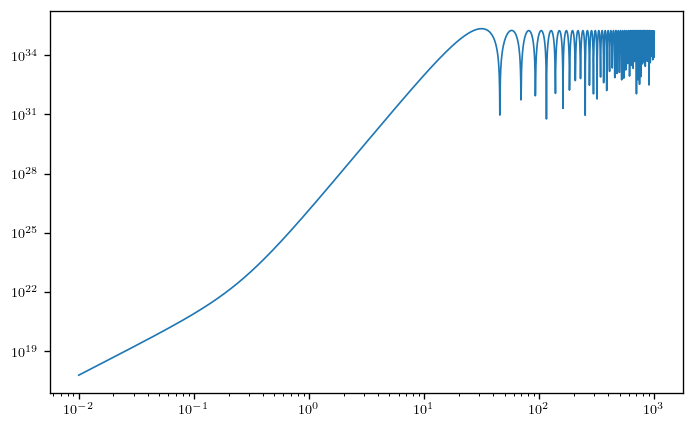

In [11]:
fig = plt.figure (dpi=120)

plt.plot (k_a, (k_a**3) * J_a[:,0], lw=mylw, label = r'$J_{00}$')

plt.xscale("log")
plt.yscale("log")



74.51385545788607 1.0135629132117


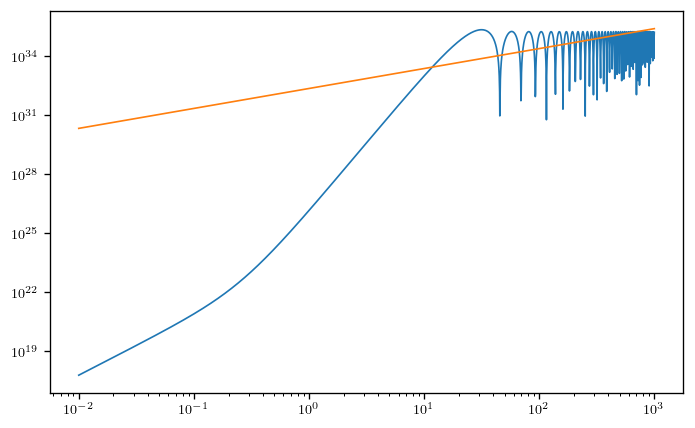

In [12]:
NPfit = 1400
k_a_fit = k_a[-NPfit:-1]
J_00_fit = J_a[-NPfit:-1,0]

a, b = np.polyfit(np.log(k_a_fit),np.log((k_a_fit**3)*J_00_fit),1)
print (b, a)

fig = plt.figure (dpi=120)

plt.plot (k_a, (k_a**3)*J_a[:,0], lw=mylw, label = r'$J_{00}$')
plt.plot (k_a, np.exp(b + a*np.log(k_a)), lw=mylw, label = r'$J_{00}$')

plt.xscale("log")
plt.yscale("log")



In [13]:
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.sin(b*2.0*np.pi*x/80.0+np.pi*c/2.0)**2

divfac = 1.0 / (5.0e32)

In [14]:
popt, pcov = curve_fit(func, k_a_fit, (k_a_fit**3)*J_00_fit*divfac,p0=[1.0, 1.0, 0.0], maxfev=10000, absolute_sigma=True)
#popt, pcov = curve_fit(func, k_a_fit, (k_a_fit**3)*J_00_fit*divfac,p0=popt)
#popt, pcov = curve_fit(func, k_a_fit, (k_a_fit**3)*J_00_fit*divfac,p0=popt)
#popt, pcov = curve_fit(func, k_a_fit, (k_a_fit**3)*J_00_fit*divfac,p0=popt)
#popt, pcov = curve_fit(func, k_a_fit, (k_a_fit**3)*J_00_fit*divfac,p0=popt)
print (popt)

[215.50943332   3.41980617 -65.28394649]


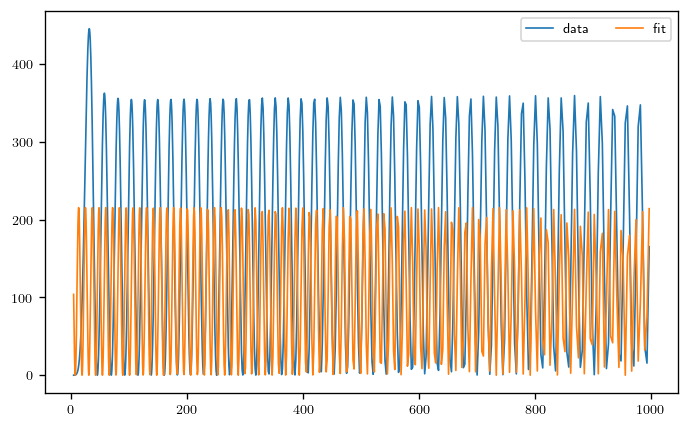

In [15]:
fig = plt.figure (dpi=120)

plt.plot (k_a_fit, (k_a_fit**3)*J_00_fit*divfac, lw=mylw, label = r'data')
plt.plot (k_a_fit, func(k_a_fit,*popt), lw=mylw, label = r'fit')
leg = plt.legend (loc="best", ncol = 2)

#plt.xscale("log")
#plt.yscale("log")

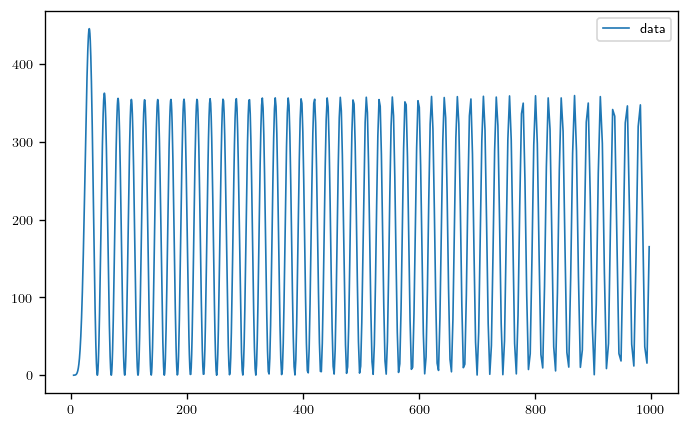

In [16]:
fig = plt.figure (dpi=120)

plt.plot (k_a_fit, k_a_fit**3*J_00_fit*divfac, lw=mylw, label = r'data')
leg = plt.legend (loc="best", ncol = 2)

#plt.xscale("log")
#plt.yscale("log")

In [17]:
np.min (J_00_fit)

3.256761202140225e+23

In [18]:
import nlopt

In [19]:
def myfunc(x, grad):
     
    Vtheo = func(k_a_fit, *x)
    Vdata = (k_a_fit**3)*J_00_fit*divfac
    
    return np.sum ((Vdata-Vtheo)**2)

opt = nlopt.opt(nlopt.LN_NELDERMEAD, 3)
opt.set_min_objective(myfunc)
opt.set_xtol_rel(1e-8)
x = opt.optimize([1.0, 1.0, 0.0])
x = opt.optimize(x)
x = opt.optimize(x)
minf = opt.last_optimum_value()
print("optimum at ", x[0], x[1], x[2])
print("minimum value = ", minf)
print("result code = ", opt.last_optimize_result())

optimum at  201.3527200980223 57.59600591561971 48.644549258212564
minimum value =  36564497.07340118
result code =  4


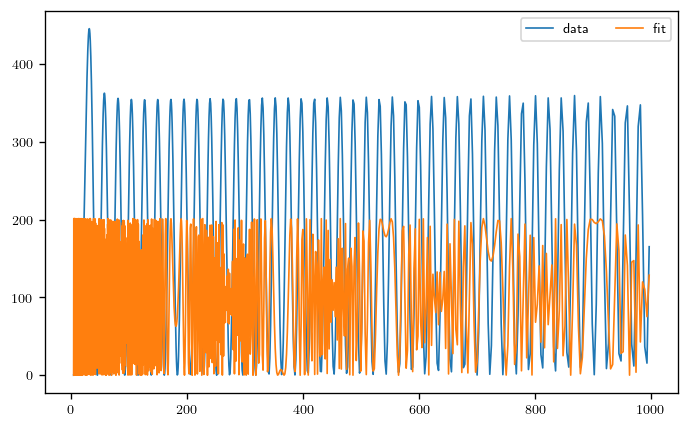

In [20]:
fig = plt.figure (dpi=120)

plt.plot (k_a_fit, (k_a_fit**3)*J_00_fit*divfac, lw=mylw, label = r'data')
plt.plot (k_a_fit, func(k_a_fit,*x), lw=mylw, label = r'fit')
leg = plt.legend (loc="best", ncol = 2)